<a href="https://colab.research.google.com/github/Imranzr/Negotiation_Based_optimisation/blob/main/Negotiation_Based_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris_on_Dataset

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Normalize the feature values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Define the fitness function
def fitness_function(agent):
    """
    Fitness function evaluates the classification accuracy using the selected features.
    Agent values closer to 1 mean the feature is selected.
    """
    selected_features = agent > 0.5  # Binary feature selection
    if not np.any(selected_features):  # Avoid cases with no selected features
        return 0

    X_selected = X[:, selected_features]
    model = RandomForestClassifier(random_state=42)
    accuracy = np.mean(cross_val_score(model, X_selected, y, cv=5))
    return accuracy

# Define the Negotiation Optimizer class
class NegotiationOptimizer:
    def __init__(self, num_agents, dim, bounds, max_iter, alpha=1, beta=1., gamma=0.035, fitness_function=None):
        self.num_agents = num_agents
        self.dim = dim
        self.bounds = bounds
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.fitness_function = fitness_function

        # Initialize agents as float type
        self.agents = np.random.uniform(bounds[0], bounds[1], (num_agents, dim))
        self.fitness = np.array([self.fitness_function(agent) for agent in self.agents])

        self.best_agent = self.agents[np.argmax(self.fitness)]
        self.best_fitness = np.max(self.fitness)

    def update_agents(self):
        ranked_indices = np.argsort(self.fitness)[::-1]
        top_agents = self.agents[ranked_indices[:self.num_agents // 2]]  # Top 50%

        for i in range(self.num_agents):
            for top_agent in top_agents:
                self.agents[i] += self.alpha * (top_agent - self.agents[i])

            partner_index = np.random.choice(len(top_agents))
            self.agents[i] = (self.gamma * self.agents[i] +
                              (1 - self.gamma) * top_agents[partner_index])
            self.agents[i] = np.clip(self.agents[i], self.bounds[0], self.bounds[1])

    def optimize(self):
        for iteration in range(self.max_iter):
            self.update_agents()
            self.fitness = np.array([self.fitness_function(agent) for agent in self.agents])

            current_best_fitness = np.max(self.fitness)
            if current_best_fitness > self.best_fitness:
                self.best_fitness = current_best_fitness
                self.best_agent = self.agents[np.argmax(self.fitness)]

            print(f"Iteration {iteration + 1}/{self.max_iter}, Best Fitness: {self.best_fitness}")

        return self.best_agent, self.best_fitness

# Set parameters for the optimizer
num_agents = 10
dim = X.shape[1]
bounds = (0, 1)
max_iter = 20

# Initialize and run the optimizer
optimizer = NegotiationOptimizer(num_agents, dim, bounds, max_iter, fitness_function=fitness_function)
best_agent, best_fitness = optimizer.optimize()

# Output results
selected_features = best_agent > 0.5
print("\nSelected Features:", selected_features)
print("Best Fitness (Accuracy):", best_fitness)


Iteration 1/20, Best Fitness: 0.9600000000000002
Iteration 2/20, Best Fitness: 0.9600000000000002
Iteration 3/20, Best Fitness: 0.9600000000000002
Iteration 4/20, Best Fitness: 0.9600000000000002
Iteration 5/20, Best Fitness: 0.9600000000000002
Iteration 6/20, Best Fitness: 0.9600000000000002
Iteration 7/20, Best Fitness: 0.9600000000000002
Iteration 8/20, Best Fitness: 0.9600000000000002
Iteration 9/20, Best Fitness: 0.9600000000000002
Iteration 10/20, Best Fitness: 0.9600000000000002
Iteration 11/20, Best Fitness: 0.9600000000000002
Iteration 12/20, Best Fitness: 0.9600000000000002
Iteration 13/20, Best Fitness: 0.9600000000000002
Iteration 14/20, Best Fitness: 0.9600000000000002
Iteration 15/20, Best Fitness: 0.9600000000000002
Iteration 16/20, Best Fitness: 0.9600000000000002
Iteration 17/20, Best Fitness: 0.9600000000000002
Iteration 18/20, Best Fitness: 0.9600000000000002
Iteration 19/20, Best Fitness: 0.9600000000000002
Iteration 20/20, Best Fitness: 0.9600000000000002

Selected

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the MCC score of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        return matthews_corrcoef(y_test, y_pred)

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}")

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness = feature_selection_niof(X, y, n_generations=10, n_agents=5)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (MCC):", best_fitness)


Generation 1/10
Agent 0 Fitness: 0.5185
Agent 1 Fitness: 0.5185
Agent 2 Fitness: 0.5185
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 2/10
Agent 0 Fitness: 0.9000
Agent 1 Fitness: 0.9000
Agent 2 Fitness: 0.9000
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 3/10
Agent 0 Fitness: 0.9000
Agent 1 Fitness: 0.9000
Agent 2 Fitness: 0.9000
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 4/10
Agent 0 Fitness: 0.9000
Agent 1 Fitness: 0.9000
Agent 2 Fitness: 0.9000
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 5/10
Agent 0 Fitness: 0.9000
Agent 1 Fitness: 0.9000
Agent 2 Fitness: 0.9000
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 6/10
Agent 0 Fitness: 0.9000
Agent 1 Fitness: 0.9000
Agent 2 Fitness: 0.9000
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 7/10
Agent 0 Fitness: 0.9000
Agent 1 Fitness: 0.9000
Agent 2 Fitness: 0.9000
Agent 3 Fitness: 0.9000
Agent 4 Fitness: 0.9000
Generation 8/10
Agent 0 Fitness: 0.9000
Agent 1 

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    matthews_corrcoef,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the MCC score of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, None, None, None, None, None  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate various metrics
        mcc = matthews_corrcoef(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        class_report = classification_report(y_test, y_pred)

        return mcc, acc, precision, recall, class_report

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf
    best_results = None

    # Optimization loop
    for generation in range(n_generations):
        print(f"\nGeneration {generation + 1}/{n_generations}")

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, acc, precision, recall, class_report = fitness_function(agent)
            print(f"Agent {i} Fitness (MCC): {fitness:.4f}")

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent
                best_results = (fitness, acc, precision, recall, class_report)

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    # Return the best agent and its results
    return alpha_agent, alpha_fitness, best_results

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness, best_results = feature_selection_niof(X, y, n_generations=10, n_agents=5)

# Display the results
selected_features = np.where(best_agent == 1)[0]
fitness, acc, precision, recall, class_report = best_results

print("\n--- Final Model Results ---")
print("Selected Features:", selected_features)
print(f"Best Fitness (MCC): {fitness:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:\n", class_report)



Generation 1/10
Agent 0 Fitness (MCC): 0.5185
Agent 1 Fitness (MCC): 0.5185
Agent 2 Fitness (MCC): 0.5185
Agent 3 Fitness (MCC): 0.9000
Agent 4 Fitness (MCC): 0.9000

Generation 2/10
Agent 0 Fitness (MCC): 0.9000
Agent 1 Fitness (MCC): 0.9000
Agent 2 Fitness (MCC): 0.9000
Agent 3 Fitness (MCC): 0.9000
Agent 4 Fitness (MCC): 0.9000

Generation 3/10
Agent 0 Fitness (MCC): 0.9000
Agent 1 Fitness (MCC): 0.9000
Agent 2 Fitness (MCC): 0.9000
Agent 3 Fitness (MCC): 0.9000
Agent 4 Fitness (MCC): 0.9000

Generation 4/10
Agent 0 Fitness (MCC): 0.9000
Agent 1 Fitness (MCC): 0.9000
Agent 2 Fitness (MCC): 0.9000
Agent 3 Fitness (MCC): 0.9000
Agent 4 Fitness (MCC): 0.9000

Generation 5/10
Agent 0 Fitness (MCC): 0.9000
Agent 1 Fitness (MCC): 0.9000
Agent 2 Fitness (MCC): 0.9000
Agent 3 Fitness (MCC): 0.9000
Agent 4 Fitness (MCC): 0.9000

Generation 6/10
Agent 0 Fitness (MCC): 0.9000
Agent 1 Fitness (MCC): 0.9000
Agent 2 Fitness (MCC): 0.9000
Agent 3 Fitness (MCC): 0.9000
Agent 4 Fitness (MCC): 0.900

Generation 1/10
Agent 0 Fitness: 0.5185, Train Loss: 0.8715, Test Loss: 0.8283
Agent 1 Fitness: 0.5185, Train Loss: 0.8715, Test Loss: 0.8283
Agent 2 Fitness: 0.5185, Train Loss: 0.8715, Test Loss: 0.8283
Agent 3 Fitness: 0.9000, Train Loss: 0.1755, Test Loss: 0.2080
Agent 4 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Generation 2/10
Agent 0 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 1 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 2 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 3 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 4 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Generation 3/10
Agent 0 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 1 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 2 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 3 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Agent 4 Fitness: 0.9000, Train Loss: 0.1586, Test Loss: 0.1987
Generat

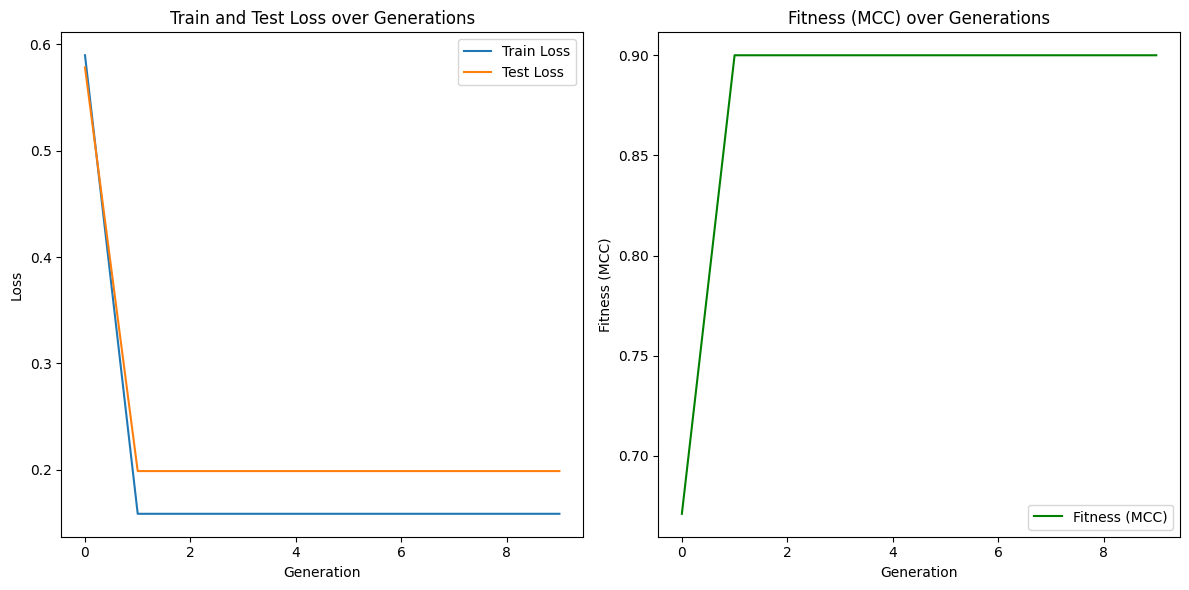

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score, log_loss
import matplotlib.pyplot as plt

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the MCC score of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_loss = log_loss(y_train, clf.predict_proba(X_train))
        test_loss = log_loss(y_test, clf.predict_proba(X_test))
        return matthews_corrcoef(y_test, y_pred_test), train_loss, test_loss

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_losses = []
    test_losses = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_loss = []
        gen_test_loss = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_loss, test_loss = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            gen_train_loss.append(train_loss)
            gen_test_loss.append(test_loss)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_losses.append(np.mean(gen_train_loss))
        test_losses.append(np.mean(gen_test_loss))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_losses, test_losses, fitness_history

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness, train_losses, test_losses, fitness_history = feature_selection_niof(X, y, n_generations=10, n_agents=5)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (MCC):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (MCC)', color='green')
plt.xlabel('Generation')
plt.ylabel('Fitness (MCC)')
plt.title('Fitness (MCC) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


#Breast Cancer

In [ ]:
import numpy as np
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    matthews_corrcoef,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    """
    Negotiation-inspired optimization algorithm for feature selection.
    """
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the MCC score of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, None, None, None, None, None  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate various metrics
        mcc = matthews_corrcoef(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        class_report = classification_report(y_test, y_pred)

        return mcc, acc, precision, recall, class_report

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf
    best_results = None

    # Optimization loop
    for generation in range(n_generations):
        print(f"\nGeneration {generation + 1}/{n_generations}")

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, acc, precision, recall, class_report = fitness_function(agent)
            print(f"Agent {i} Fitness (MCC): {fitness:.4f}")

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent
                best_results = (fitness, acc, precision, recall, class_report)

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    # Return the best agent and its results
    return alpha_agent, alpha_fitness, best_results

# Load datasets
datasets = {"Breast Cancer": load_breast_cancer()}

for dataset_name, data in datasets.items():
    print(f"\n--- Applying NIOF on {dataset_name} Dataset ---")
    X, y = data.data, data.target

    # Apply the feature selection method
    best_agent, best_fitness, best_results = feature_selection_niof(X, y, n_generations=10, n_agents=5)

    # Display the results
    selected_features = np.where(best_agent == 1)[0]
    fitness, acc, precision, recall, class_report = best_results

    print("\n--- Final Model Results ---")
    print(f"Dataset: {dataset_name}")
    print("Selected Features:", selected_features)
    print(f"Best Fitness (MCC): {fitness:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n", class_report)



--- Applying NIOF on Breast Cancer Dataset ---

Generation 1/10
Agent 0 Fitness (MCC): 0.8869
Agent 1 Fitness (MCC): 0.8483
Agent 2 Fitness (MCC): 0.9054


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 3 Fitness (MCC): 0.9054
Agent 4 Fitness (MCC): 0.9064

Generation 2/10
Agent 0 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064
Agent 3 Fitness (MCC): 0.9064
Agent 4 Fitness (MCC): 0.9064

Generation 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064
Agent 3 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness (MCC): 0.9064

Generation 4/10
Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 3 Fitness (MCC): 0.9064
Agent 4 Fitness (MCC): 0.9064

Generation 5/10
Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 2 Fitness (MCC): 0.9064
Agent 3 Fitness (MCC): 0.9064
Agent 4 Fitness (MCC): 0.9064

Generation 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064
Agent 3 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness (MCC): 0.9064

Generation 7/10
Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 3 Fitness (MCC): 0.9064
Agent 4 Fitness (MCC): 0.9064

Generation 8/10
Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 2 Fitness (MCC): 0.9064
Agent 3 Fitness (MCC): 0.9064
Agent 4 Fitness (MCC): 0.9064

Generation 9/10
Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064
Agent 3 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness (MCC): 0.9064

Generation 10/10
Agent 0 Fitness (MCC): 0.9064
Agent 1 Fitness (MCC): 0.9064
Agent 2 Fitness (MCC): 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 3 Fitness (MCC): 0.9064
Agent 4 Fitness (MCC): 0.9064

--- Final Model Results ---
Dataset: Breast Cancer
Selected Features: [ 0  2  5  6  8  9 10 20 22 23 24 29]
Best Fitness (MCC): 0.9064
Accuracy: 0.9561
Precision: 0.9565
Recall: 0.9561

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.97      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#Validation_on_Wine_dataset

Generation 1/10
Agent 0 Fitness: 0.8056, Train Accuracy: 0.9085, Test Accuracy: 0.8056
Agent 1 Fitness: 0.9444, Train Accuracy: 0.9577, Test Accuracy: 0.9444
Agent 2 Fitness: 0.9167, Train Accuracy: 0.9718, Test Accuracy: 0.9167
Agent 3 Fitness: 0.9167, Train Accuracy: 0.9366, Test Accuracy: 0.9167
Agent 4 Fitness: 0.6667, Train Accuracy: 0.7113, Test Accuracy: 0.6667
Generation 2/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9444, Train Accuracy: 0.9577, Test Accuracy: 0.9444
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Generation 10/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 1 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 2 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 3 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722
Agent 4 Fitness: 0.9722, Train Accuracy: 0.9789, Test Accuracy: 0.9722

Best Agent (Selected Features): [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Best Fitness (Accuracy): 0.9722222222222222


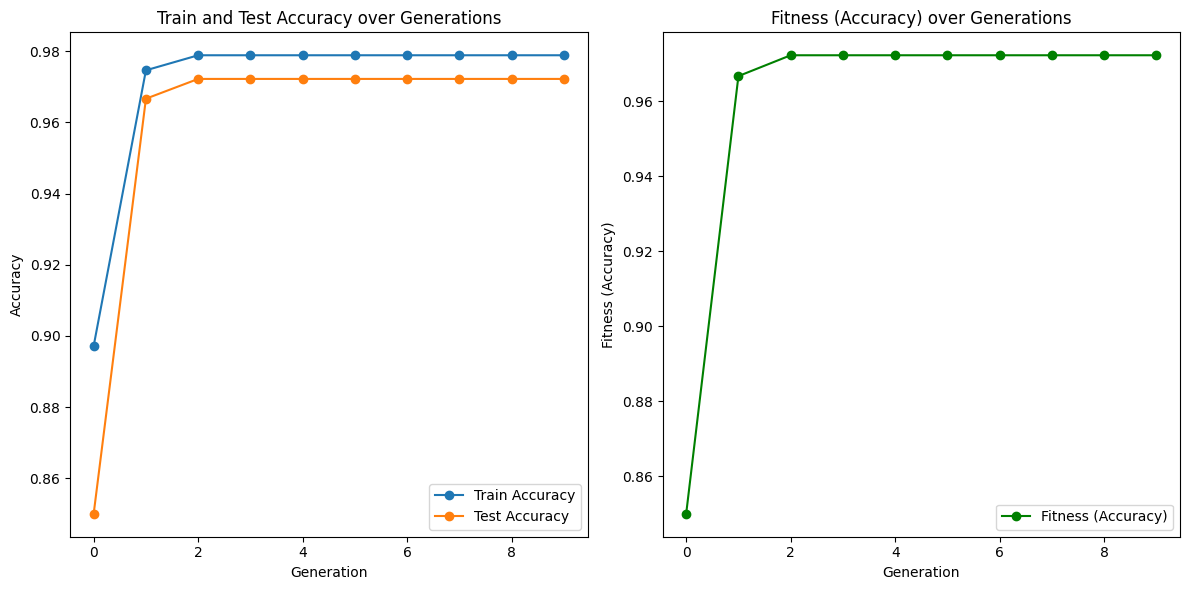

In [ ]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the Wine dataset
data = load_wine()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    X, y, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


#Validation_on_digits_dataset

Generation 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9056, Train Accuracy: 0.9673, Test Accuracy: 0.9056


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.8889, Train Accuracy: 0.9360, Test Accuracy: 0.8889


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.8944, Train Accuracy: 0.9527, Test Accuracy: 0.8944


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9056, Train Accuracy: 0.9749, Test Accuracy: 0.9056
Generation 2/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9556, Train Accuracy: 1.0000, Test Accuracy: 0.9556


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 10/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528

Best Agent (Selected Features): [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 56 58 59 60 61 62 63]
Best Fitness (Accuracy): 0.9555555555555556


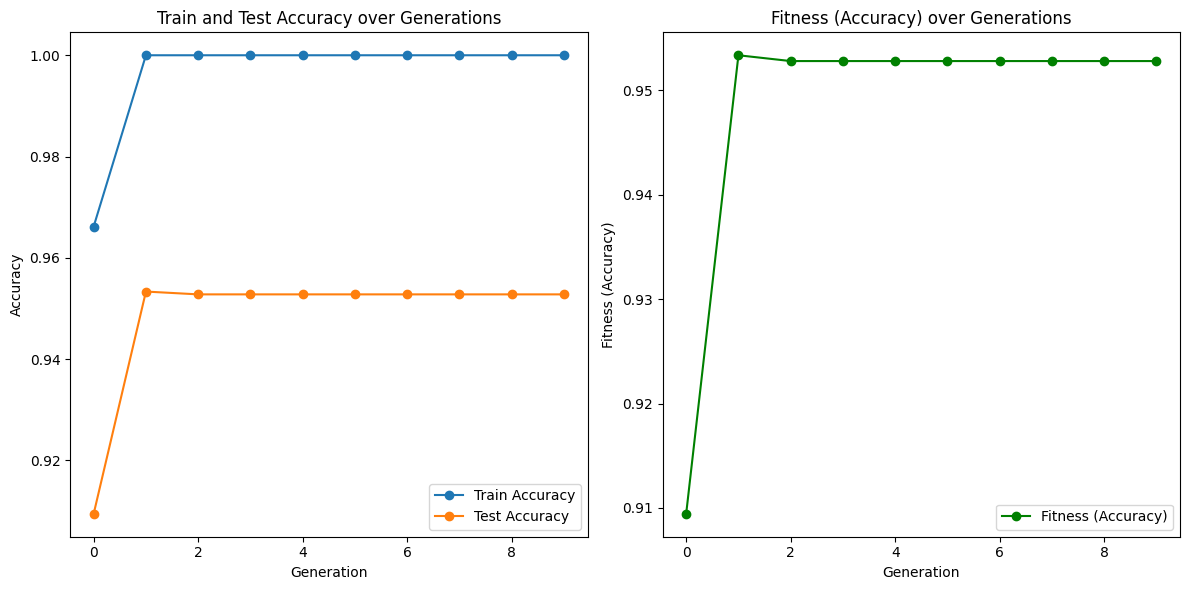

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the Digits dataset
data = load_digits()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    X, y, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


# Breast Cancer Wisconsin Dataset

Generation 1/10
Agent 0 Fitness: 0.9474, Train Accuracy: 0.9538, Test Accuracy: 0.9474
Agent 1 Fitness: 0.9298, Train Accuracy: 0.9451, Test Accuracy: 0.9298
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9560, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9516, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness: 0.9561, Train Accuracy: 0.9429, Test Accuracy: 0.9561
Generation 2/10
Agent 0 Fitness: 0.9649, Train Accuracy: 0.9516, Test Accuracy: 0.9649
Agent 1 Fitness: 0.9649, Train Accuracy: 0.9516, Test Accuracy: 0.9649


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 3/10
Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 4/10
Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 6/10
Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 8/10
Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Generation 10/10
Agent 0 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 1 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561
Agent 4 Fitness: 0.9561, Train Accuracy: 0.9495, Test Accuracy: 0.9561

Best Agent (Selected Features): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Best Fitness (Accuracy): 0.9649122807017544


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


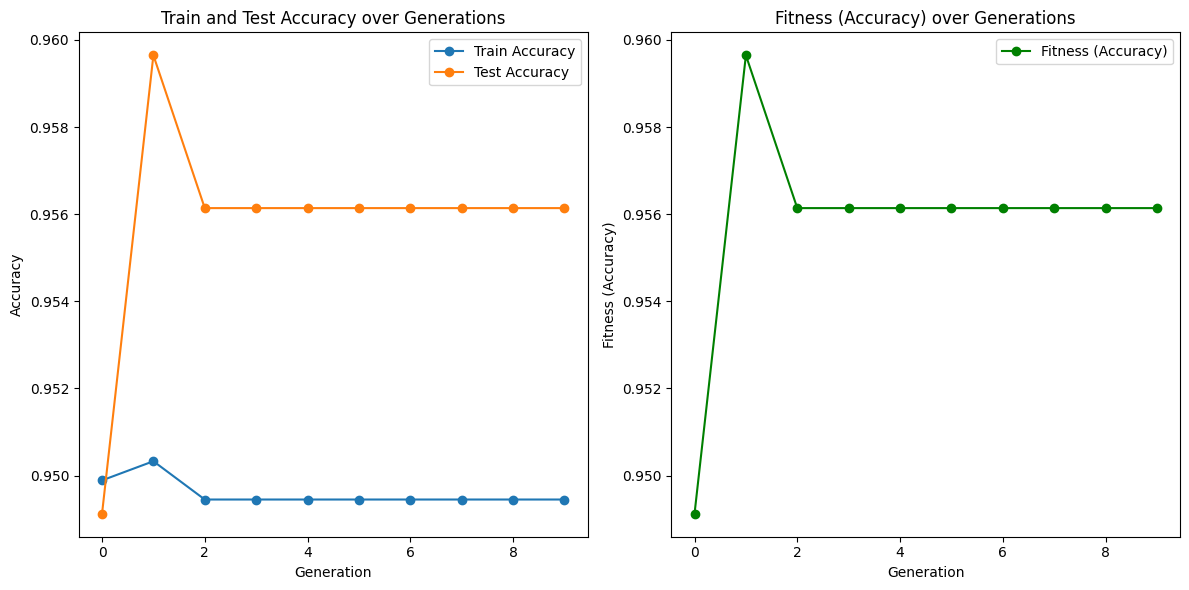

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    X, y, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


#  Digits dataset consists of 8x8 images of handwritten digits (0-9)

Generation 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9056, Train Accuracy: 0.9673, Test Accuracy: 0.9056


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.8889, Train Accuracy: 0.9360, Test Accuracy: 0.8889


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.8944, Train Accuracy: 0.9527, Test Accuracy: 0.8944


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9056, Train Accuracy: 0.9749, Test Accuracy: 0.9056
Generation 2/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9556, Train Accuracy: 1.0000, Test Accuracy: 0.9556


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528
Generation 10/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.9528, Train Accuracy: 1.0000, Test Accuracy: 0.9528

Best Agent (Selected Features): [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 56 58 59 60 61 62 63]
Best Fitness (Accuracy): 0.9555555555555556


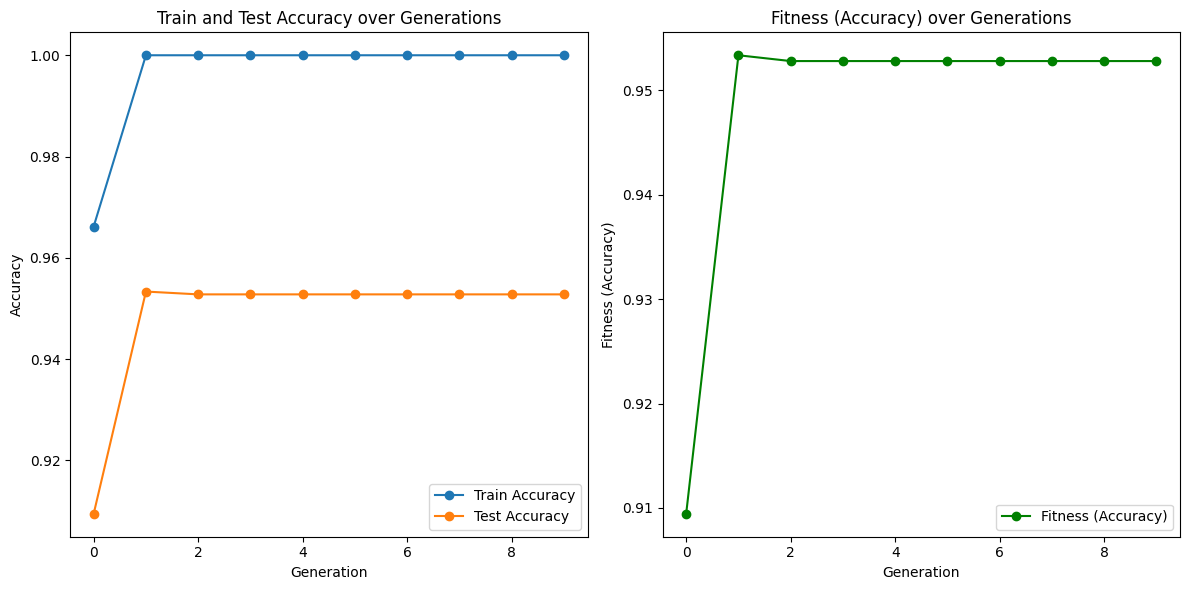

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the Digits dataset
data = load_digits()
X, y = data.data, data.target

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    X, y, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


# CIFAR-10 Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import cifar10

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Flatten the images
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    x_train_flat, y_train, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


Generation 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

#Fashion MNIST Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, stratify=labels, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Flatten the images
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    x_train_flat, y_train, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Generation 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.8518, Train Accuracy: 0.8626, Test Accuracy: 0.8518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.8519, Train Accuracy: 0.8615, Test Accuracy: 0.8519


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.8512, Train Accuracy: 0.8625, Test Accuracy: 0.8512


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.8516, Train Accuracy: 0.8639, Test Accuracy: 0.8516


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.8518, Train Accuracy: 0.8657, Test Accuracy: 0.8518
Generation 2/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.8562, Train Accuracy: 0.8719, Test Accuracy: 0.8562


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572
Generation 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 4 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572
Generation 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 0 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 1 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 2 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Agent 3 Fitness: 0.8572, Train Accuracy: 0.8765, Test Accuracy: 0.8572


KeyboardInterrupt: 

#The Breast Cancer Wisconsin (Diagnostic) Dataset

Generation 1/10
Agent 0 Fitness: 0.9561, Train Accuracy: 0.9516, Test Accuracy: 0.9561
Agent 1 Fitness: 0.9649, Train Accuracy: 0.9495, Test Accuracy: 0.9649
Agent 2 Fitness: 0.9561, Train Accuracy: 0.9538, Test Accuracy: 0.9561
Agent 3 Fitness: 0.9737, Train Accuracy: 0.9473, Test Accuracy: 0.9737
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 2/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 3/10
Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 6/10
Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 9/10
Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Generation 10/10
Agent 0 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 1 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Agent 2 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 3 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825
Agent 4 Fitness: 0.9825, Train Accuracy: 0.9319, Test Accuracy: 0.9825

Best Agent (Selected Features): [ 0  2  5  6  8  9 10 20 22 23 24 29]
Best Fitness (Accuracy): 0.9824561403508771


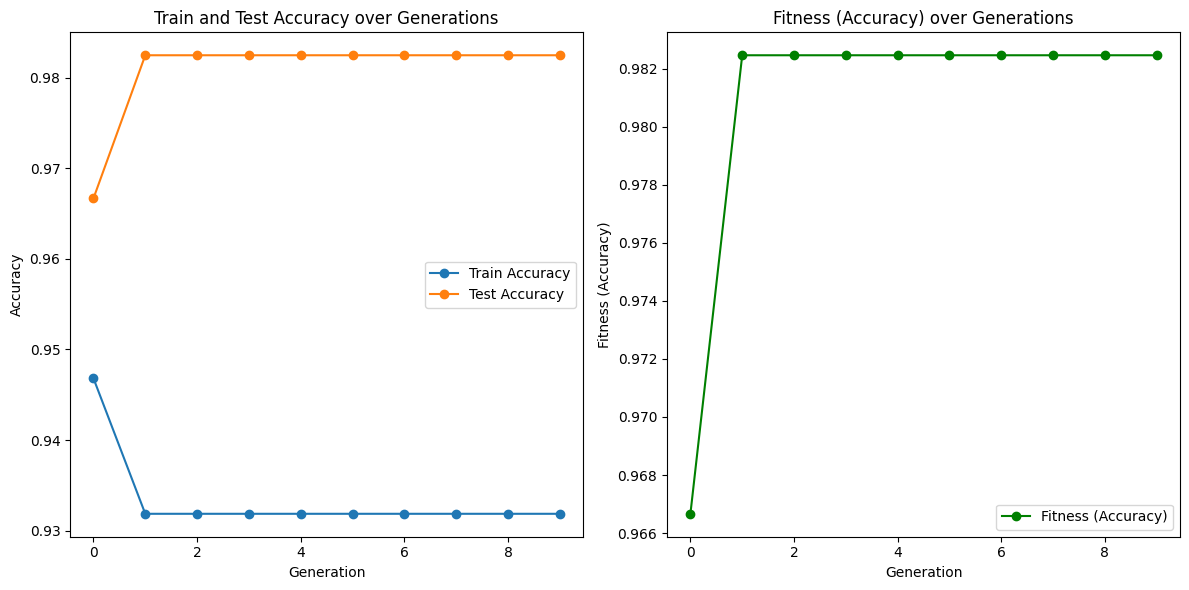

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 0.25, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Load the Breast Cancer dataset
cancer_data = load_breast_cancer()
X = cancer_data.data  # Features (30 features)
y = cancer_data.target  # Labels (Malignant: 0, Benign: 1)

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    X, y, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()


# Validation_on_titanic_dataset

<ipython-input-3-0ca8bab01b98>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
<ipython-input-3-0ca8bab01b98>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})


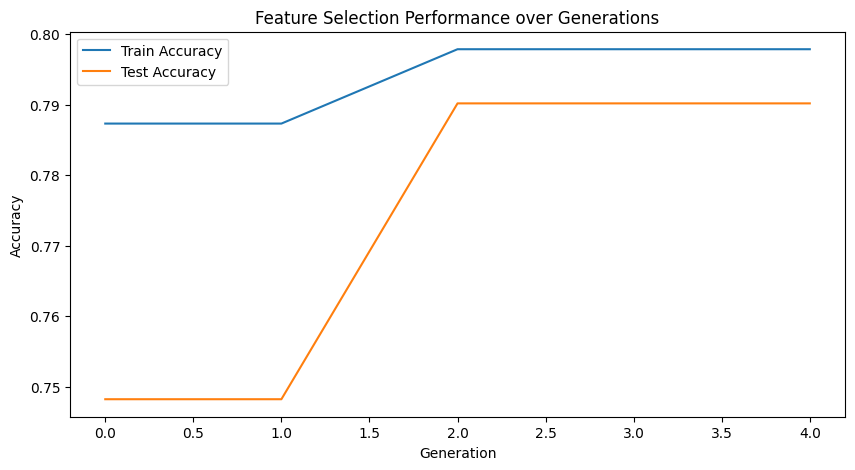

Best feature selection strategy: [1 1 1 1 1]
Best fitness value: 0.7902097902097902


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the Titanic dataset from seaborn
titanic = sns.load_dataset('titanic')

# Preprocessing: Drop rows with missing values and select relevant features
titanic = titanic.dropna(subset=['age', 'embarked', 'sex', 'pclass', 'fare', 'survived'])

# Encode categorical variables
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Prepare features and target variable
X = titanic[['age', 'sex', 'pclass', 'fare', 'embarked']].values
y = titanic['survived'].values

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data[:, selected_features], labels, test_size=0.2, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Feature selection generations
    for generation in range(n_generations):
        # Evaluate fitness of agents
        fitness_values = np.array([fitness_function(agent)[0] for agent in agents])

        # Update best solution (alpha)
        max_fitness_idx = np.argmax(fitness_values)
        if fitness_values[max_fitness_idx] > alpha_fitness:
            alpha_fitness = fitness_values[max_fitness_idx]
            alpha_agent = agents[max_fitness_idx]

        # Reproduce agents: Keep the best agents, randomly mutate the others
        new_agents = agents.copy()
        for i in range(n_agents):
            if i != max_fitness_idx:  # For all but the best agent
                new_agents[i] = np.random.randint(2, size=n_features)

        agents = new_agents

        # Track metrics for visualization
        train_accuracies.append(fitness_function(alpha_agent)[1])
        test_accuracies.append(fitness_function(alpha_agent)[2])
        fitness_history.append(alpha_fitness)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(n_generations), train_accuracies, label='Train Accuracy')
    plt.plot(range(n_generations), test_accuracies, label='Test Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.title('Feature Selection Performance over Generations')
    plt.legend()
    plt.show()

    return alpha_agent, alpha_fitness

# Run the feature selection process
alpha_agent, alpha_fitness = feature_selection_niof(X, y, n_generations=5, n_agents=3)
print(f"Best feature selection strategy: {alpha_agent}")
print(f"Best fitness value: {alpha_fitness}")


# Validation_on_pima-indians-diabetes

Generation 1/10
Agent 0 Fitness: 0.7662, Train Accuracy: 0.7622, Test Accuracy: 0.7662
Agent 1 Fitness: 0.7468, Train Accuracy: 0.7492, Test Accuracy: 0.7468
Agent 2 Fitness: 0.7662, Train Accuracy: 0.7557, Test Accuracy: 0.7662
Agent 3 Fitness: 0.7792, Train Accuracy: 0.7704, Test Accuracy: 0.7792
Agent 4 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Generation 2/10
Agent 0 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 1 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 2 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 3 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 4 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Generation 3/10
Agent 0 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 1 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 2 Fitness: 0.7727, Train Accuracy: 0.7410, Test Accuracy: 0.7727
Agent 3 Fitness: 0.7727, Trai

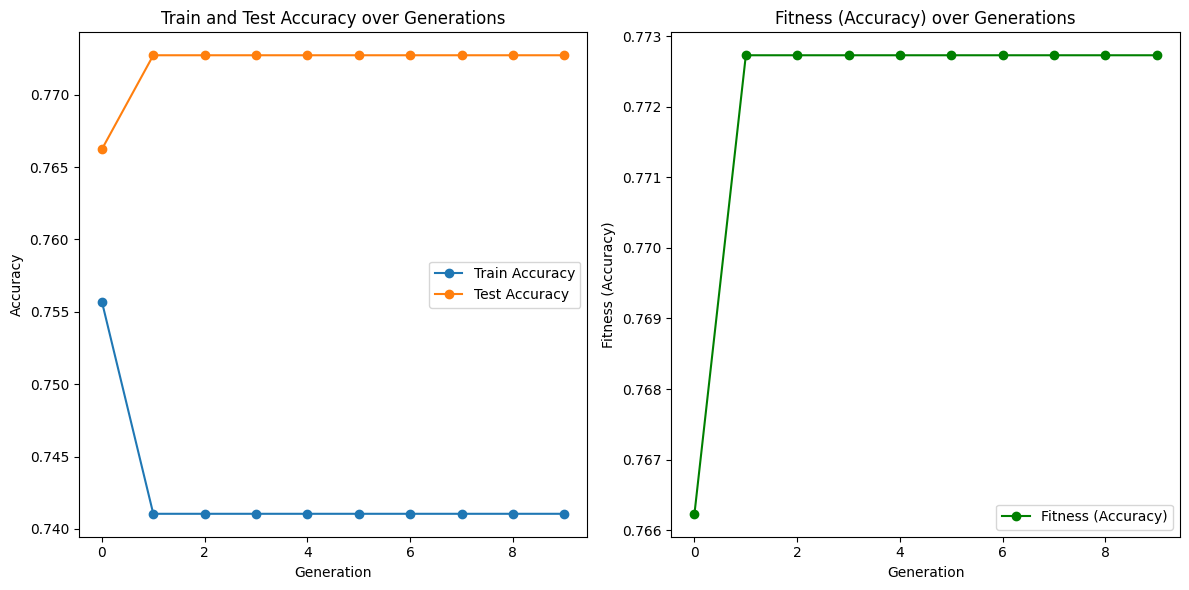

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Prepare the features (X) and labels (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Normalize the features
X = (X - X.mean()) / X.std()

def feature_selection_niof(data, labels, n_generations=2, n_agents=3, random_seed=42):
    np.random.seed(random_seed)
    n_features = data.shape[1]

    # Initialize agent strategies (binary representation of feature selection)
    agents = np.random.randint(2, size=(n_agents, n_features))

    def fitness_function(solution):
        """
        Evaluate the fitness of an agent by the accuracy of a Logistic Regression model.
        """
        selected_features = np.where(solution == 1)[0]  # Selected features
        if len(selected_features) == 0:
            return 0, 0, 0  # Avoid empty feature sets
        X_train, X_test, y_train, y_test = train_test_split(
            data.iloc[:, selected_features], labels, test_size=0.2, random_state=random_seed
        )
        clf = LogisticRegression(max_iter=100, random_state=random_seed)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        return test_accuracy, train_accuracy, test_accuracy

    # Initialize alpha agent (best solution)
    alpha_agent = None
    alpha_fitness = -np.inf

    # Tracking metrics for plotting
    train_accuracies = []
    test_accuracies = []
    fitness_history = []

    # Optimization loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")

        gen_train_acc = []
        gen_test_acc = []
        gen_fitness = []

        # Evaluate each agent's strategy
        for i, agent in enumerate(agents):
            fitness, train_acc, test_acc = fitness_function(agent)
            print(f"Agent {i} Fitness: {fitness:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            gen_train_acc.append(train_acc)
            gen_test_acc.append(test_acc)
            gen_fitness.append(fitness)

            if fitness > alpha_fitness:
                alpha_fitness = fitness
                alpha_agent = agent

        train_accuracies.append(np.mean(gen_train_acc))
        test_accuracies.append(np.mean(gen_test_acc))
        fitness_history.append(np.mean(gen_fitness))

        # Negotiation-inspired updates
        for i in range(n_agents):
            for j in range(n_agents):
                if i != j:
                    negotiation_factor = agents[i] - agents[j]
                    agents[i] = np.where(negotiation_factor > 1.2, alpha_agent, agents[j])

    return alpha_agent, alpha_fitness, train_accuracies, test_accuracies, fitness_history

# Apply the feature selection method
best_agent, best_fitness, train_accuracies, test_accuracies, fitness_history = feature_selection_niof(
    X, y, n_generations=10, n_agents=5
)

# Display the results
selected_features = np.where(best_agent == 1)[0]
print("\nBest Agent (Selected Features):", selected_features)
print("Best Fitness (Accuracy):", best_fitness)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Generations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fitness_history, label='Fitness (Accuracy)', color='green', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness (Accuracy) over Generations')
plt.legend()

plt.tight_layout()
plt.show()
